In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


## Data Preparation

In [2]:
# Load the data
# Input data files are available in the "../input/" directory.
train_images = pd.read_csv("../input/digit-recognizer/train.csv")
test_images = pd.read_csv("../input/digit-recognizer/test.csv")
print("train_images shape", train_images.shape)
print("test_images shape", test_images.shape)

train_images shape (42000, 785)
test_images shape (28000, 784)


In [3]:
train_images.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Prepare the data for train and test
y_train = train_images["label"]

# Drop 'label' column
X_train = train_images.drop(labels = ["label"],axis = 1) 

# free some space
del train_images

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

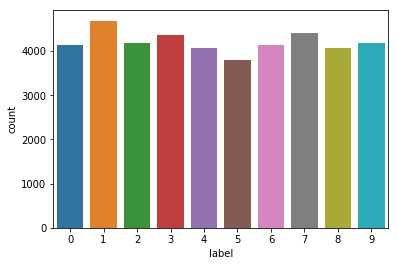

In [5]:
g = sns.countplot(y_train)

y_train.value_counts()

### Check for null and missing values

In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test_images.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

### Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [8]:
# Normalize the data
X_train = X_train / 255.0
test_images = test_images / 255.0

### Reshape

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [9]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = test_images.values.reshape(-1,28,28,1)

In [10]:
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

X_train shape (42000, 28, 28, 1)
X_test shape (28000, 28, 28, 1)


### Label encoding

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

In [11]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

### Split training and valdiation set

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

In [12]:
# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.1, 
                                                  random_state=random_seed)

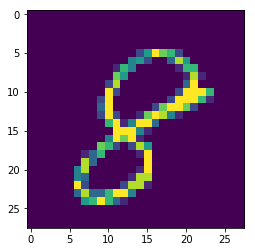

In [13]:
# Let's visualising one image and looking at the label.
# Some examples
plt.imshow(X_train[0][:,:,0])

## Define the model

In [14]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [15]:
# model.summary() # 887,530

### Set the optimizer and annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed RMSprop (with default values), it is a very effective optimizer. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [16]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [17]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [18]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
model.fit(X_train, Y_train, epochs=30, batch_size=86, validation_data = (X_val,Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
37800/37800 [==============================] - 9s 227us/step - loss: 0.2435 - accuracy: 0.9226 - val_loss: 0.0686 - val_accuracy: 0.9793
Epoch 2/30
37800/37800 [==============================] - 4s 98us/step - loss: 0.0732 - accuracy: 0.9779 - val_loss: 0.0628 - val_accuracy: 0.9814
Epoch 3/30
37800/37800 [==============================] - 4s 95us/step - loss: 0.0549 - accuracy: 0.9837 - val_loss: 0.0358 - val_accuracy: 0.9895
Epoch 4/30
37800/37800 [==============================] - 3s 93us/step - loss: 0.0444 - accuracy: 0.9863 - val_loss: 0.0327 - val_accuracy: 0.9907
Epoch 5/30
37800/37800 [==============================] - 4s 95us/step - loss: 0.0389 - accuracy: 0.9881 - val_loss: 0.0362 - val_accuracy: 0.9905
Epoch 6/30
37800/37800 [==============================] - 4s 94us/step - loss: 0.0357 - accuracy: 0.9896 - val_loss: 0.0445 - val_accuracy: 0.9910
Epoch 7/30
37800/37800 [==============================] - 3s 92us/st

In [20]:
#arr = arr.astype('float64')
predictions = model.predict(X_test)
# argmax will choose the value having max probability
model_res = np.argmax(predictions, axis=1)

In [21]:
#Print our predicitons as number labels for the first 4 images
print(model_res[:4])

[2 0 9 9]


In [22]:
# create sample submission file and submit
pred = pd.DataFrame(model_res)
sub_df = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
datasets = pd.concat([sub_df['ImageId'], pred], axis =1)
datasets.columns = ['ImageId', 'Label']
datasets.to_csv("sample_submission.csv", index = False)

### At this stage I have got a score of 0.98642. I will try to improve score by implementing data augumentation

## Data augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

* Without data augmentation i obtained an accuracy of 98.642%
* With data augmentation i achieved 99.52% of accuracy

In [23]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

For the data augmentation, i choosed to :

* Randomly rotate some training images by 10 degrees
* Randomly Zoom by 10% some training images
* Randomly shift images horizontally by 10% of the width
* Randomly shift images vertically by 10% of the height

I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset 

In [24]:
batch_size = 86
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/50
 - 13s - loss: 0.1860 - accuracy: 0.9536 - val_loss: 0.0431 - val_accuracy: 0.9907
Epoch 2/50
 - 12s - loss: 0.1298 - accuracy: 0.9668 - val_loss: 0.0512 - val_accuracy: 0.9893
Epoch 3/50
 - 12s - loss: 0.1148 - accuracy: 0.9704 - val_loss: 0.0516 - val_accuracy: 0.9902
Epoch 4/50
 - 12s - loss: 0.1012 - accuracy: 0.9741 - val_loss: 0.0344 - val_accuracy: 0.9905

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
 - 12s - loss: 0.0753 - accuracy: 0.9789 - val_loss: 0.0369 - val_accuracy: 0.9924
Epoch 6/50
 - 13s - loss: 0.0737 - accuracy: 0.9799 - val_loss: 0.0312 - val_accuracy: 0.9936
Epoch 7/50
 - 12s - loss: 0.0742 - accuracy: 0.9805 - val_loss: 0.0478 - val_accuracy: 0.9917
Epoch 8/50
 - 12s - loss: 0.0681 - accuracy: 0.9812 - val_loss: 0.0535 - val_accuracy: 0.9910
Epoch 9/50
 - 12s - loss: 0.0691 - accuracy: 0.9806 - val_loss: 0.0602 - val_accuracy: 0.9898

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118

In [25]:
#arr = arr.astype('float64')
predictions = model.predict(X_test)
# argmax will choose the value having max probability
model_res = np.argmax(predictions, axis=1)

In [26]:
# create sample submission file and submit
pred = pd.DataFrame(model_res)
sub_df = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
datasets = pd.concat([sub_df['ImageId'], pred], axis =1)
datasets.columns = ['ImageId', 'Label']
datasets.to_csv("sample_submission_datagen.csv", index = False)

At this instant my submission has scored 0.99528. 